# CAPSTONE - Battle of Neighborhood

## - Help Jamie to find an ideal apartment

### 1. Question 

The Final project is going to explore the most suitable apartment based on the background of “Jamie”. Jamie just graduated from college and was ready to go to work in New York city. This is the first time that Jamie goes to New York, there is no friend who can help him. Therefore, Jamie want to use data science tool to analyze where he should rent. Some basic information can be followed: 

1. Jamie doesn’t have a plan to buy a car within 2 years, so the place should be convenient on transportation. 
2. Jamie’s company is in Manhattan area. 
3. Jamie’s income is average level, and it is better the control the rental within certain price. 

The information should be based on different elements, like transportation, apartment price, metro, etc. 

The project is for people who just move to New York city without any information about apartment or neighborhoods. People can find apartment informations with different levels and different stypes. Besides, there is also neighborhood information people can track and get more familiar about New york city. 


In [2]:
import numpy as np
import pandas as pd
import requests 
import folium 
import os 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from IPython.display import display_html
from sklearn.cluster import KMeans

Solving environment: - 
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0
  - defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::openssl-1.1.1d-h1de35ccdone

# All requested packages already installed.



### 2. Data

1. We should gather the Manhattan apartment information from website, the data can be found in rentmanhattan.com. There is a list that show every apartment name with their rental price, also we can track the address in this website. 
http://www.rentmanhattan.com/index.cfm?page=search&state=results
besides, the data list that we used in previous project with longitude and latitude was used in this capstone project in order to improve the result. the data included the specific apartment address and longitute and latitude, it is more convenient to visualize in the map. people can read the position and relative distance directly. 


2. We should use metro station information to identify convenience of transportation, the data can be found in wikipedia. there are subway statation including station name, line name and location. 
https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan
besides, longitude and latitude of metro station were obtained in FourSquare in order to apply into the visualization. 
https://github.com/destipan/Coursera_Capstone-1/blob/master/MH_rent_latlong.csv

3. We should use neighborhoods and boroughs, latitudes and longitudes to identify the convenience of neighborhoods, the dat can be found in new york dataset. There are specific information about new york neighbors, like restaurant, musium, post office, etc. We can use this dataset to identify the surrounding neighbors. 
https://cocl.us/new_york_dataset

and all data will be obtained via FourSquare API 


### 3. Methodology

#### The methodology will be contributed by three aspects. 

##### Dataframe and list
the dataframe and list that were generated by pandas and numpy library directly show the imformation to people. It may not the clearest way but it will prepare all information people want to know. Sometimes, when we do data analysis, people have to more and less delete some non-core information. For example, in this project, the metro station information was deleted to only include address, longitude and latitude. However, the station name and metro line name may be required for people who want to know more. Data list is the way that prepare every specific information for that people. 

##### data visualization
The data visualization generated by Matplotlib and seaborn and folium library gives the most clearest result that show what people are looking for. In this project, there are mainly three kinds of plot that showed in analysis part, histogram, box plots, and map. 

##### clustering 
The clustering was used under dataset is unlabeled, nad process is unsupervised, and a cluster is a group of objects that are similar to other objects in the cluster, and dissimilar to data points in other clusters. In this project, clustering method mainly was used to cluster the New York city areas. 

### 4. Data Analysis and Result

#### Extracted and filtered data

In [3]:
CLIENT_ID = 'YEJU1W3IL5E2YMTN3OHJVKVEBNJ4XC5SR0TL1RFAEYAEBKMX' # your Foursquare ID
CLIENT_SECRET = 'EATU1VBPHO2XBT0ITFXZHNKXSJEM5P5N25X1F0RVGFVPFBMM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [17]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [5]:
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [6]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


This list prepare all information about New York city Borough and each neighborhood with their latitude and longitude respectively. People can know more about New York city according to this information. 

In [7]:
df = ny_data[ny_data.Borough == 'Manhattan']
df.head()

,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688


From the background information, Jamie works in Manhattan and doesn't have a car, so he may prefer to live close to his workplace. The Manhattan Borough information was extracted. 

In [13]:
URL1 = requests.get('https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan').text
bs = BeautifulSoup(URL1, 'lxml')
table = str(bs.table)
df1 = pd.read_html(table, flavor = 'bs4')
infer_types=False
df11 = df1[0]
df11.head()

,Division,Line,Services,Stations in Manhattan,Opened,Continues to
0,B (IND),Second Avenue Line,​​,3,"January 1, 2017",NaN
1,B (IND),Sixth Avenue Line,​​​,"13 (6 express-local stations, 5 part of statio...","January 1, 1936",Brooklyn
2,B (IND),Eighth Avenue Line,​​​​,"30 (9 express-local stations,[^ 2] 7 part of s...","September 10, 1932",Brooklyn
3,A (IRT),42nd Street Line,NaN,2 (both part of station complexes),"October 27, 1904",NaN
4,B (BMT),63rd Street Line,​​,1 (shared with IND 63rd Street Line),"October 29, 1989[^ 5]",NaN


The list of metro station in Manhattan was extracted from wikipedia page. It included line name, station name and address. 

In [15]:
search_query = 'subway'
radius = 2000
print(search_query + ' .... OK!')

subway .... OK!


In [19]:
latitude = 40.758896
longitude = -73.985130
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url2
results = requests.get(url2).json()
results

{'meta': {'code': 200, 'requestId': '5ecf69b469babe001b68fa5b'},
 'response': {'venues': [{'id': '4b0737c3f964a520e4f922e3',
    'name': 'MTA Subway - 42nd St/Times Square/Port Authority Bus Terminal (A/C/E/N/Q/R/W/S/1/2/3/7)',
    'location': {'address': 'W 42nd St',
     'crossStreet': 'btwn Broadway & 8th Ave',
     'lat': 40.75589107939994,
     'lng': -73.98788975509518,
     'distance': 407,
     'postalCode': '10036',
     'cc': 'US',
     'neighborhood': 'Theater District',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['W 42nd St (btwn Broadway & 8th Ave)',
      'New York, NY 10036',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1fd931735',
      'name': 'Metro Station',
      'pluralName': 'Metro Stations',
      'shortName': 'Metro',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1590651433',

In [20]:
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe.head()

/Users/destipan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.distance,...,location.country,location.formattedAddress,location.labeledLatLngs,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4b0737c3f964a520e4f922e3,MTA Subway - 42nd St/Times Square/Port Authori...,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590651433,False,W 42nd St,btwn Broadway & 8th Ave,40.755891,-73.987890,407,...,United States,"[W 42nd St (btwn Broadway & 8th Ave), New York...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4b0b2275f964a520772d23e3,MTA Subway - 47th-50th St/Rockefeller Center (...,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590651433,False,Avenue of the Americas,47th - 50th St,40.758770,-73.981215,330,...,United States,"[Avenue of the Americas (47th - 50th St), New ...","[{'label': 'display', 'lat': 40.75876953696506...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4b1e78c2f964a520461a24e3,MTA Subway - 59th St/Columbus Circle (A/B/C/D/1),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590651433,False,59th St / Columbus Circle,at Central Park S,40.768742,-73.981904,1129,...,United States,[59th St / Columbus Circle (at Central Park S)...,"[{'label': 'display', 'lat': 40.76874242789886...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4b54f3d6f964a520ecd427e3,MTA Subway - 7th Ave (B/D/E),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590651433,False,W. 53rd St,7th Ave,40.762923,-73.981942,522,...,United States,"[W. 53rd St (7th Ave), New York, NY 10009, Uni...","[{'label': 'display', 'lat': 40.76292273751926...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4adcd010f964a5206e3021e3,MTA Subway - 42nd St/Bryant Park (B/D/F/M/7),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590651433,False,Ave of the Americas,at 42nd St,40.753690,-73.984859,579,...,United States,"[Ave of the Americas (at 42nd St), New York, N...","[{'label': 'display', 'lat': 40.75369041570710...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
df_filtered = dataframe_filtered[dataframe_filtered['categories'] == 'Sandwich Place'].index
dataframe_filtered.drop(df_filtered, inplace = True)
dataframe_filtered.head()

,name,categories,address,crossStreet,lat,lng,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,labeledLatLngs,id
0,MTA Subway - 42nd St/Times Square/Port Authori...,Metro Station,W 42nd St,btwn Broadway & 8th Ave,40.755891,-73.987890,407,10036,US,Theater District,New York,NY,United States,"[W 42nd St (btwn Broadway & 8th Ave), New York...",NaN,4b0737c3f964a520e4f922e3
1,MTA Subway - 47th-50th St/Rockefeller Center (...,Metro Station,Avenue of the Americas,47th - 50th St,40.758770,-73.981215,330,10020,US,NaN,New York,NY,United States,"[Avenue of the Americas (47th - 50th St), New ...","[{'label': 'display', 'lat': 40.75876953696506...",4b0b2275f964a520772d23e3
2,MTA Subway - 59th St/Columbus Circle (A/B/C/D/1),Metro Station,59th St / Columbus Circle,at Central Park S,40.768742,-73.981904,1129,10019,US,NaN,New York,NY,United States,[59th St / Columbus Circle (at Central Park S)...,"[{'label': 'display', 'lat': 40.76874242789886...",4b1e78c2f964a520461a24e3
3,MTA Subway - 7th Ave (B/D/E),Metro Station,W. 53rd St,7th Ave,40.762923,-73.981942,522,10009,US,NaN,New York,NY,United States,"[W. 53rd St (7th Ave), New York, NY 10009, Uni...","[{'label': 'display', 'lat': 40.76292273751926...",4b54f3d6f964a520ecd427e3
4,MTA Subway - 42nd St/Bryant Park (B/D/F/M/7),Metro Station,Ave of the Americas,at 42nd St,40.753690,-73.984859,579,10036,US,NaN,New York,NY,United States,"[Ave of the Americas (at 42nd St), New York, N...","[{'label': 'display', 'lat': 40.75369041570710...",4adcd010f964a5206e3021e3


In order to get more specific metro station information, the location data including latitude, longitude, postal code, etc. was generated by FourSquire, and it will be used in data visualization section. 

In [23]:
url3 = 'https://raw.githubusercontent.com/destipan/Coursera_Capstone-1/master/MH_rent_latlong.csv'
NY_LL = pd.read_csv(url3, error_bad_lines = False)
NY_LL.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


The core of this project is preparing apartment information for Jamie, so the apartment rental information that was used in previous project is reused in this project. The list included apartment address, price, room type, and their lat/long respectively. 

#### Data Visualization

In [27]:
map1 = folium.Map(location = [40.758896, -73.985130], zoom_start = 10)
for lat, lng, borough, neighborhood in zip (df['Latitude'], df['Longitude'], df['Borough'],df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = 'red', fill=True, fill_opacity = 0.7, parse_html=False).add_to(map1)
map1

For the first visualization is a map that included neighborhood information in Manhattan. THe neighborhood locations were provided for people who try to devide which neighborhood that they want to settle down. 

In [29]:
metro_map = folium.Map(location=[latitude, longitude], zoom_start=13) 
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(metro_map)

metro_map

This map provides metro station locations in Manhattan. 

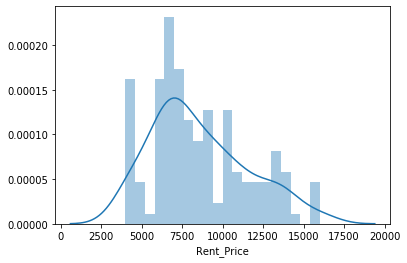

In [32]:
His1 = sns.distplot(NY_LL['Rent_Price'], bins = 20)

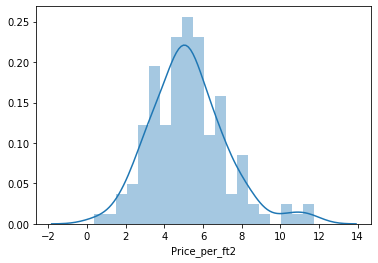

In [33]:
His2 = sns.distplot(NY_LL['Price_per_ft2'], bins = 20)

There are two histograms that show the distribution of rental price and price per square feet. From these two histogram, we can know the distribution generally meet the normal distribution. the mean of rental price is around 7500, and the price per square feet is around 5. 

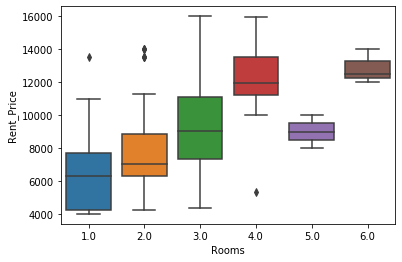

In [34]:
box1 = sns.boxplot(x = 'Rooms', y = 'Rent_Price', data = NY_LL)

This boxplot showed the relationship between rental price and room numbers. We can see the price goes up with increasing room number, instead of 5-room apartment. There is a big decent point at 5-room part. 

In [35]:
latitude = 40.758896
longitude = -73.985130

map_rent = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, label in zip(NY_LL['Lat'], NY_LL['Long'],'$ ' + NY_LL['Rent_Price'].astype(str)+ ',  '+ NY_LL['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rent) 
    
for lat, lng, label in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],  dataframe_filtered['address'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_rent) 
    
map_rent

This is a map that combined apartment information and metro station information. 

#### Clustering

In [37]:
rent_c = NY_LL.drop(['Address', 'Area'], axis=1)
rent_c.head()

This is a map including the clustering information. the neighboorhood was divided into 5 clusters showed in this map. It was used to help people who are new in New York to know better about locations. 

In [44]:
cluster1 = ny_data.loc[ny_data['Cluster Labels'] == 0, ny_data.columns[[2] + list(range(5, ny_data.shape[1]))]]
cluster1

,Neighborhood
49,Greenpoint
61,Williamsburg
62,Bushwick
63,Bedford Stuyvesant
64,Brooklyn Heights
...,...
279,Fulton Ferry
280,Vinegar Hill
283,Dumbo
301,Hudson Yards


This is for testing clustering

In [50]:
rent_c = NY_LL.drop(['Address', 'Area'], axis=1)
from sklearn.preprocessing import StandardScaler
X = rent_c.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
rent_c["Clus_km"] = labels

In [51]:
rent_c.groupby('Clus_km').mean()

,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
Clus_km,,,,,,
0,5.972500,2.625000,1833.750000,9770.875000,40.755996,-73.981890
1,6.259615,3.230769,2673.653846,13475.653846,40.753611,-73.978258
2,0.350000,3.000000,22200.000000,7795.000000,40.715887,-74.005873
3,3.367895,1.947368,1526.842105,4481.578947,40.759692,-73.972320
4,4.960172,2.241379,1468.034483,6893.206897,40.753732,-73.981419


In [52]:
NY_LL["Clus_km"] = labels
NY_LL

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long,Clus_km
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213,0
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277,4
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213,3
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873,3
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299,3
...,...,...,...,...,...,...,...,...,...
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,40.769465,-73.960339,0
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,40.714051,-74.009608,0
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,40.758216,-73.965190,4
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,40.772474,-73.981901,4


In [53]:
latitude = 40.758896
longitude = -73.985130

clusterNum = 5
rent_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(clusterNum)
ys = [i+x+(i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(NY_LL['Lat'], NY_LL['Long'], NY_LL['Address'], NY_LL['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(rent_clusters)
 
    
       
rent_clusters

In [63]:
cluster3 = NY_LL.loc[NY_LL['Clus_km'] == 3, NY_LL.columns[[1] + list(range(0, NY_LL.shape[1]))]]
cluster3_filtered = cluster3.drop(['Area'], axis = 1)
cluster3_filtered

,Address,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long,Clus_km
2,West 105th Street,1.89,4.0,2800,5300,40.799771,-73.966213,3
3,CARMINE ST.,3.03,2.0,1650,5000,40.730523,-74.001873,3
4,171 W 23RD ST.,3.45,2.0,1450,5000,40.744118,-73.995299,3
5,76 CARMINE ST.,3.56,2.0,1350,4800,40.729631,-74.004440,3
6,E 91ST,3.21,2.0,1450,4650,40.781059,-73.949421,3
7,333 east 81st street,1.85,3.0,2430,4500,40.774324,-73.952836,3
8,EAST 88TH STREET,3.21,2.0,1400,4500,40.779176,-73.950794,3
9,East 77th Street,5.00,1.0,900,4500,40.772969,-73.958253,3
10,W 23RD ST.,2.21,2.0,2040,4500,40.742323,-73.991433,3
11,EAST 30TH STREET,2.09,2.0,2150,4500,40.741660,-73.976261,3


The map and list above showed the clusters of apartment in Manhattan area based on the price and room numbers, etc. 5 clusters were set up for kmeans analysis. From above, the mean room number is around 2 or 3 based on the kmeans. and cluster 3 was picked for finding a suitable apartment based on the lowest mean rental price. 

### 5. Discussion 

From the histogram and boxplot, we can know 5-bedroom may be the cheapest choice, but 5-bedroom has a small area per person, and bad area. It is ideal to choose less bedroom apartment for Jamie to change better user experience. **There are three apartments Jamie may be willing to move in.**

##### Apartment 1

As the result, the apartment of **4 bedrooms** at **West 105th Street** in Upper West side with **5300-dollar rental** has the highest cost-effective. Its price per ft2 is 1.89, although it is not the lowest, it gives us the lowest price per bedroom. We also can know the location is in updown of Manhattan area, the neighboorhood can provide almost everything to Jamie. 

However, there is a defect at that location. We can see there is no metro station at that area, and if Jamie's company is not close to his apartment, he only can take bus or uber because he doesn't have willingness to buy a car within 2 years. 

For this option, it is prepared for novice in the workplace with not many deposits. This apartment gives people a best value and a good user experience. 

##### Apartment 2

As the result, the apartment of **2 bedrooms** at **W 23RD ST**. around midtown with **4500-dollar rental** has a relatively higher user experience. Its price per ft2 is 2.21, and it has 2020 square feet area. Jamie can get larger personal area in this apartment, and also this apartment is close to metro station. Jamie can go everywhere easily by subway. Besides, midtown is more prosperous than uptown, Jamie can get a better user experience than apartment. The defect is the rental price is almost double by apartment 1. 

For this option, it is prepared for novice in the workplace with some deposits or not many deposits, but the job income is optimistic, and the rental is not a big burden for tenants. 

##### Apartment 3

As the result, the apartment of 1 bedroom at 135 W 24TH ST. around midtown with 4200-dollar rental has a extremely good user experience. If Jamie prefer to live alone in Manhattan (it is not big possible as a green hand), this apartment will be the best choice. The position is at midtown, and the price is relatively low within single bedroom apartment. Besides, the traffic here is well developed, Jamie can choose many different ways, like subway, uber, bus, etc. The defect is the rental price. 

For this option, it is prepared for people who have already had some deposits and are willing to enjoy their lives. 

### 6. Conclusion 

As I talked above, Jamie definitely can find an ideal apartment. There are three apartments provided for Jamie, and he can pick one based on his background and demand. Besides, if Jamie doesn't like these three apartments, he also can find one from the information I provided. 

The map and plot tools are the most efficient, and they can deliver the information clearly and intuitively. People just click on the blue or red dot in the map to know what the apartment is and what the price the apartment is. Besides, according to the histogram and box, people can know the trend and general information about the rental. 

For further project, the clusters should be set up more specifically based on different parameters, and the range should be more wilder. In this project, I only considered apartment in Manhattan, but more choices in other borough should be supplied. 


**Finally, I must say thank you to IBM, it provides this amazing program to teach people who are interested in data science world. I really enjoy it and will keep studying on it!**